# SBC for the sinusoidal model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from scipy.stats import binom, norm
import random

from bayesflow.networks import InvertibleNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.models import GenerativeModel

In [2]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # Prior range: frequency parameter a ~ U(0.1, 1) & shift parameter b ~ N(0, 0.25²)
    freq_samples = np.random.uniform(0.1, 1.0, size=(batch_size, 1))
    shift_samples = np.random.normal(0.0, 0.25, size=(batch_size, 1))
    p_samples = np.c_[freq_samples, shift_samples]
    return p_samples.astype(np.float32)
      
n_obs = 41  
time_points = np.linspace(0, 10, n_obs)
sigma = 0.05   # noise standard deviation
missing_max = 21

def batch_simulator_augment01(prior_samples, n_obs):   
    """
    Simulate multiple oscillatory model data sets with missing values and binary augmentation
    """    
    n_sim = prior_samples.shape[0]   # batch size    
    sim_data = np.ones((n_sim, n_obs, 2), dtype=np.float32)   # 1 batch consisting of n_sim datasets, each with n_obs observations  
    n_missing = np.random.randint(0, missing_max+1, size=n_sim)
    
    for m in range(n_sim):
        a = prior_samples[m, 0]   # frequency
        b = prior_samples[m, 1]   # shift
        sim_data[m, :, 0] = np.sin(a*2*np.pi*time_points) + b + np.random.normal(0, sigma, size=n_obs)
        
        # artificially induce missing data
        missing_indices = random.sample(range(n_obs), n_missing[m])
        sim_data[m][missing_indices] = np.array([-5.0, 0.0])
        
    return sim_data 

We build an amortized parameter estimation network.

In [3]:
bf_meta = {
    'n_coupling_layers': 5,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 2
}

## Generate test data sets

In [4]:
n_sbc = 5000
n_post_samples_sbc = 250
params_sbc = prior(n_sbc)
x_augment01 = batch_simulator_augment01(params_sbc, n_obs)

## Sample from BayesFlow using the different encodings

In [6]:
%%time

# Augment by 0/1
summary_net = LSTM(128)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
ParameterEstimationTrainer(network=amortizer, checkpoint_path='./Oscillation41_augment01_5ACB_[64,64,64]_LSTM(128)_ckpts', skip_checks=True)

# BayesFlow samples from the learned posterior
param_samples_augment01 = amortizer.sample(x_augment01, n_post_samples_sbc)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./Oscillation41_augment01_5ACB_[64,64,64]_LSTM(128)_ckpts\ckpt-300
Wall time: 55.1 s


In [10]:
%%time

# Insert -5
summary_net = LSTM(128)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
ParameterEstimationTrainer(network=amortizer, checkpoint_path='./Oscillation41_insert-5_5ACB_[64,64,64]_LSTM(128)_ckpts', skip_checks=True)

x_insert = np.ones((n_sbc, n_obs, 1), dtype=np.float32)
for m in range(n_sbc):
    x_insert[m, :, 0] = x_augment01[m, :, 0]
    
# BayesFlow samples from the learned posterior    
param_samples_insert = amortizer.sample(x_insert, n_post_samples_sbc)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./Oscillation41_insert-5_5ACB_[64,64,64]_LSTM(128)_ckpts\ckpt-300
Wall time: 57.4 s


In [12]:
%%time

# Time labels
summary_net = LSTM(128)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
ParameterEstimationTrainer(network=amortizer, checkpoint_path='./Oscillation41_timepoints_5ACB_[64,64,64]_LSTM(128)_ckpts', skip_checks=True)

# BayesFlow samples from the learned posterior
param_samples_time = np.empty((n_sbc, n_post_samples_sbc, 2), dtype=np.float32)
for m in range(n_sbc):
    x = x_augment01[m, :, 1]
    present_indices = np.where(x == 1.)[0]
    x_time = np.empty((1, len(present_indices), 2), dtype=np.float32)
    x_time[0, :, 0] = x_augment01[m, present_indices, 0]
    x_time[0, :, 1] = time_points[present_indices]
    param_samples_time[m] = amortizer.sample(x_time, n_post_samples_sbc)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./Oscillation41_timepoints_5ACB_[64,64,64]_LSTM(128)_ckpts\ckpt-300
Wall time: 9min 40s


## Plotting method

In [13]:
def plot_sbc(axarr, theta_samples, theta_test, param_names, bins=25, interval=0.99):
    """ Plots the simulation-based posterior checking histograms as advocated by Talts et al. (2018). """

    # Plot settings
    N = int(theta_test.shape[0])

    # Compute ranks (using broadcasting)    
    ranks = np.sum(theta_samples < theta_test[:, np.newaxis, :], axis=1)
    
    # Compute interval
    endpoints = binom.interval(interval, N, 1 / bins)

    # Plot histograms
    for j in range(len(param_names)):
        
        # Add interval
        axarr[j].axhspan(endpoints[0], endpoints[1], facecolor='gray', alpha=0.3)
        axarr[j].axhline(np.mean(endpoints), color='gray', zorder=0, alpha=0.5)
        
        sns.histplot(ranks[:, j], kde=False, ax=axarr[j], color='#a34f4f', bins=bins, alpha=0.95)
        
        axarr[j].set_title(param_names[j])
        axarr[j].spines['right'].set_visible(False)
        axarr[j].spines['top'].set_visible(False)
        if j == len(param_names) - 1:
            axarr[j].set_xlabel('Rank statistic')
        axarr[j].get_yaxis().set_ticks([])
        axarr[j].set_ylabel('')

## SBC histograms

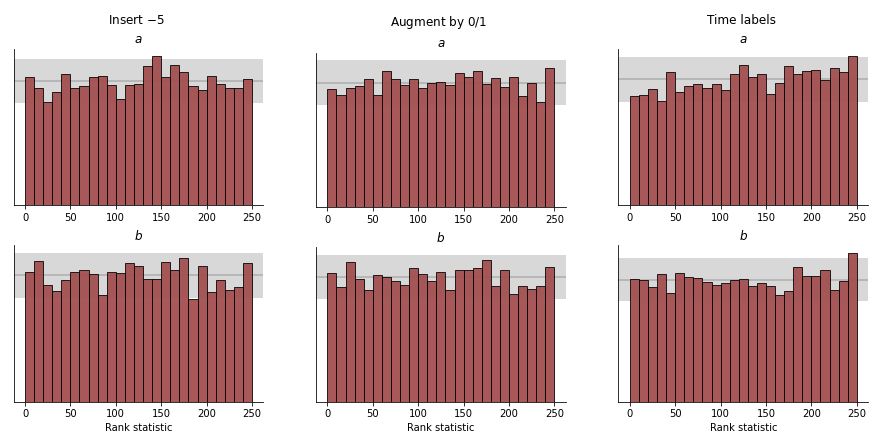

In [14]:
fig = plt.figure(figsize=(12, 6), constrained_layout=True)
subfigs = fig.subfigures(nrows=1, ncols=3, wspace=0.15)
all_axes = [subfig.subplots(nrows=2, ncols=1, gridspec_kw={'wspace': 0}) for subfig in subfigs.ravel()]

for ix, (samples, label) in enumerate([
    (param_samples_insert, "Insert $-5$"),
    (param_samples_augment01, "Augment by $0/1$"),
    (param_samples_time, "Time labels")
]):
    axes = all_axes[ix].flat
    plot_sbc(axes, samples, params_sbc, ["$a$", "$b$"])
    subfigs[ix].suptitle(label)
    if ix > 0:
        for ax in axes:
            ax.set_ylabel(None)
plt.suptitle(" ", fontsize=0.1)

for fmt in ["png", "pdf"]:
    fig.savefig(f"figures/Osc_sbc.{fmt}", dpi=300, bbox_inches='tight')